In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import matplotlib.pyplot as plt
import os
import numpy as np
torch.manual_seed(0)

In [2]:
from advertorch.test_utils import LeNet5
from advertorch_examples.utils import TRAINED_MODEL_PATH

filename = "mnist_lenet5_clntrained.pt"

model = LeNet5()
model.load_state_dict(
    torch.load(os.path.join(TRAINED_MODEL_PATH, filename))
)

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

LeNet5(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu1): ReLU(inplace=True)
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2): ReLU(inplace=True)
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (linear1): Linear(in_features=3136, out_features=200, bias=True)
  (relu3): ReLU(inplace=True)
  (linear2): Linear(in_features=200, out_features=10, bias=True)
)

In [3]:
import torch.nn.functional as F
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc_1 = nn.Linear(28*28*1, 64)
        self.fc_2 = nn.Linear(64, 128)
        self.fc_3 = nn.Linear(128, 10)

    def forward(self, x):
        out = x.view(x.size(0), -1)
        out = F.relu(self.fc_1(out))
        out = F.relu(self.fc_2(out))
        out = self.fc_3(out)

        return out

model = MLP()

model.load_state_dict(
    torch.load("data/model_checkpoint.pt")
)

model.to(device)

MLP(
  (fc_1): Linear(in_features=784, out_features=64, bias=True)
  (fc_2): Linear(in_features=64, out_features=128, bias=True)
  (fc_3): Linear(in_features=128, out_features=10, bias=True)
)

In [4]:
from advertorch_examples.utils import get_mnist_test_loader
loader = get_mnist_test_loader(batch_size=5)
for cln_data, true_label in loader:
    break
cln_data, true_label = cln_data.to(device), true_label.to(device)

In [5]:
from advertorch.attacks import GradientSignAttack

adversary = GradientSignAttack(
    model, loss_fn=nn.CrossEntropyLoss(reduction="sum"), eps=0.15, targeted=False
)

In [6]:
adv_untargeted = adversary.perturb(cln_data, true_label)

target = torch.ones_like(true_label)*3
adversary.targeted = True
adv_targeted = adversary.perturb(cln_data, target)

In [7]:
cln_data[0].shape

torch.Size([1, 28, 28])

In [11]:
model(cln_data).max(dim=1, keepdim=False)[1]

tensor([7, 2, 1, 0, 4], device='cuda:0')

In [12]:
model(adv_untargeted).max(dim=1, keepdim=False)[1]

tensor([3, 3, 7, 7, 7], device='cuda:0')

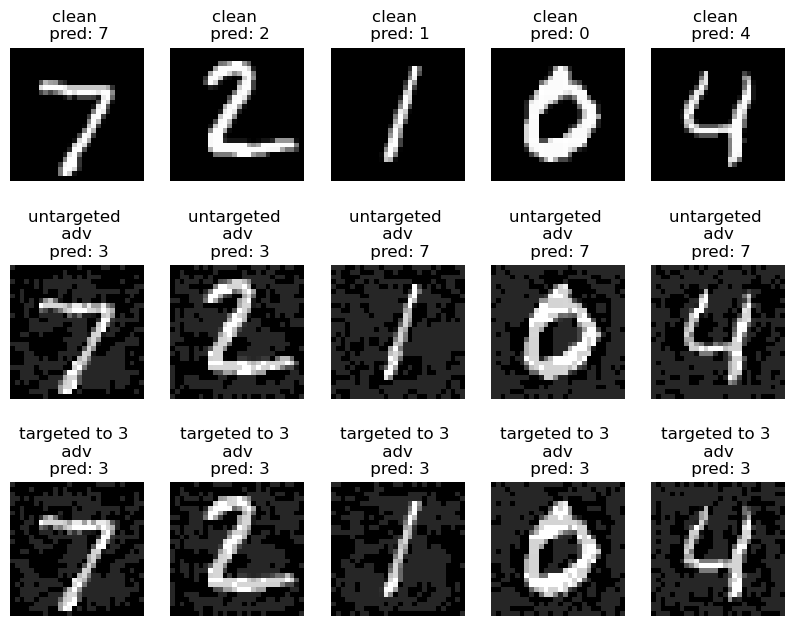

In [9]:
# Visualization of attacks
from advertorch.utils import predict_from_logits
from advertorch_examples.utils import _imshow

model.eval()
pred_cln = predict_from_logits(model(cln_data))
pred_untargeted = predict_from_logits(model(adv_untargeted))
pred_targeted = predict_from_logits(model(adv_targeted))

plt.figure(figsize=(10,8))
for ii in range(5):
    plt.subplot(3, 5, ii+1)
    _imshow(cln_data[ii])
    plt.title("clean \n pred: {}".format(pred_cln[ii]))
    plt.subplot(3,5, ii+1+5)
    _imshow(adv_untargeted[ii])
    plt.title("untargeted \n adv \n pred: {}".format(pred_untargeted[ii]))
    plt.subplot(3,5, ii+1+5*2)
    _imshow(adv_targeted[ii])
    plt.title("targeted to 3 \n adv \n pred: {}".format(pred_targeted[ii]))

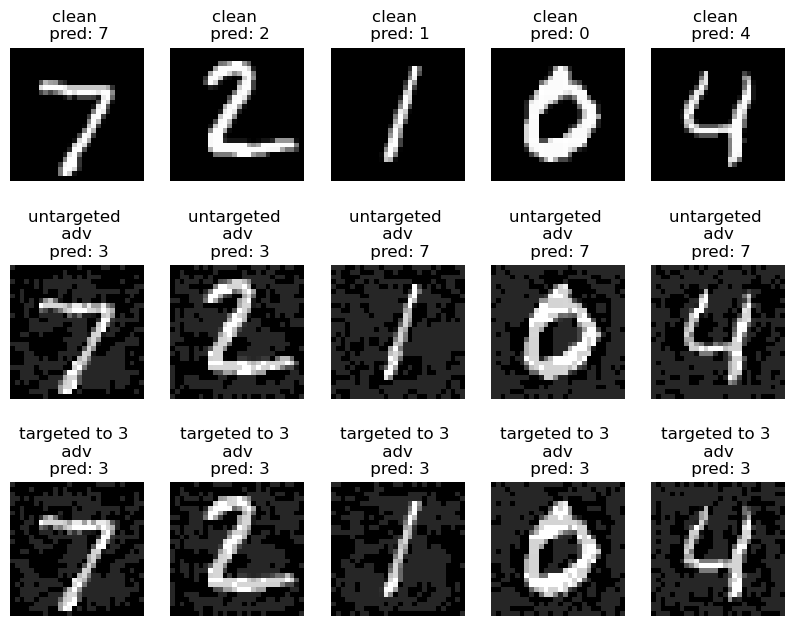

In [30]:
# Visualization of attacks
from advertorch.utils import predict_from_logits
from advertorch_examples.utils import _imshow

# net.eval()
pred_cln = predict_from_logits(model(cln_data))
pred_untargeted = predict_from_logits(model(adv_untargeted))
pred_targeted = predict_from_logits(model(adv_targeted))

plt.figure(figsize=(10,8))
for ii in range(5):
    plt.subplot(3, 5, ii+1)
    _imshow(cln_data[ii])
    plt.title("clean \n pred: {}".format(pred_cln[ii]))
    plt.subplot(3,5, ii+1+5)
    _imshow(adv_untargeted[ii])
    plt.title("untargeted \n adv \n pred: {}".format(pred_untargeted[ii]))
    plt.subplot(3,5, ii+1+5*2)
    _imshow(adv_targeted[ii])
    plt.title("targeted to 3 \n adv \n pred: {}".format(pred_targeted[ii]))